In [1]:
import numpy as np
import pandas as pd

import scipy as sp
import scipy.stats as stats

import arviz as az
import pymc as pm

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

## Data

In [2]:
import pickle as pk

path = 'drive/MyDrive/DATA/'
file_name = 'data_sharks.pickle'

with open(path+file_name, 'rb') as f:
    data = pk.load(f)

data.keys()

dict_keys(['hammerhead', 'mako', 'tiger_shark', 'great_white', 'megalodon'])

## EDA

In [3]:
outs_len = {key:[len(i) for i in data[key]['outs']] for key in data.keys()}
inps_len = {key:[len(i) for i in data[key]['inputs']] for key in data.keys()}

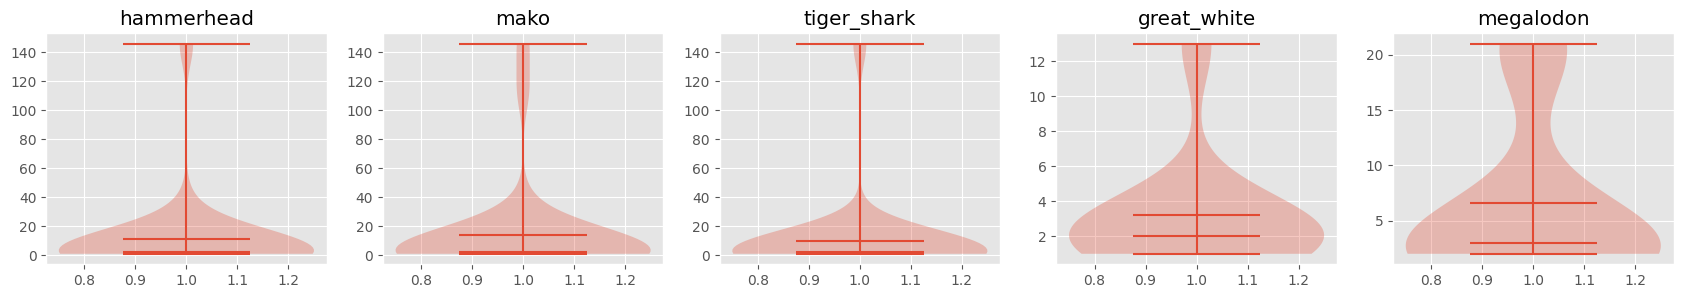

In [7]:
fit, axs = plt.subplots(1, len(outs_len.keys()), figsize=(21, 3))

for i, shark in enumerate(outs_len.keys()):
    axs[i].violinplot(outs_len[shark], showmeans=True, showmedians=True)
    axs[i].set_title(shark)

## Model

In [8]:
outs = np.array([x for xs in list(outs_len.values()) for x in xs])
categories_o = np.array(list(data.keys()))
idx_o = pd.Categorical([key for key, val in outs_len.items() for i in val], categories_o).codes
groups_o = len(np.unique(idx_o))

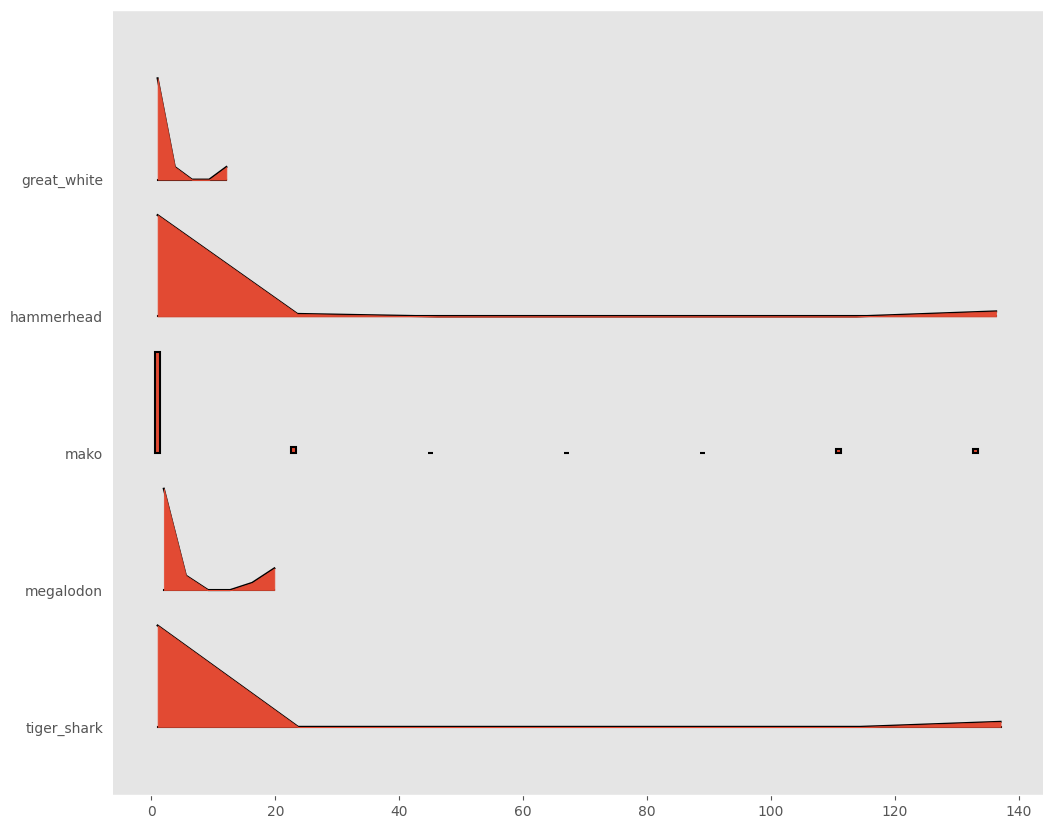

In [9]:
az.plot_forest(outs_len, kind='ridgeplot', hdi_prob=1);

In [ ]:
idx_o

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4], dtype=int8)

Output()

array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

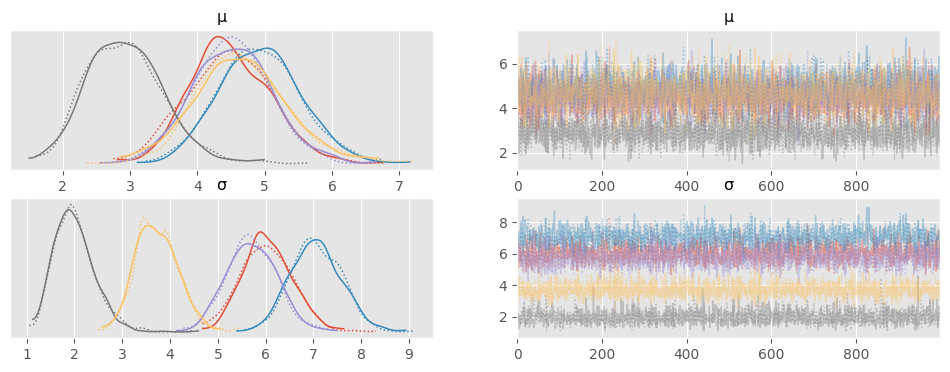

In [10]:
with pm.Model() as comparing_groups_outs:
    μ = pm.HalfNormal('μ', sigma=5, shape=groups_o)
    σ = pm.HalfNormal('σ', sigma=1, shape=groups_o)

    y = pm.Gamma('y', mu=μ[idx_o], sigma=σ[idx_o], observed=outs)

    idata_o = pm.sample()

az.plot_trace(idata_o)

In [11]:
inputs = np.array([x for xs in list(inps_len.values()) for x in xs])
categories_i = np.array(list(data.keys()))
idx_i = pd.Categorical([key for key, val in inps_len.items() for i in val], categories_i).codes
groups_i = len(np.unique(idx_i))

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:595: RuntimeWarning: invalid value encountered in sqrt
  rhat_value = np.sqrt(
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/usr/local/lib/python3.11/dist-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.11/dist-packages/arviz/stats/density_utils.py:700: RuntimeWarning: divide by zero encountered in divide
  f = grid_counts / bin_width / len(x)
/usr/local/lib/python3.

OverflowError: cannot convert float infinity to integer

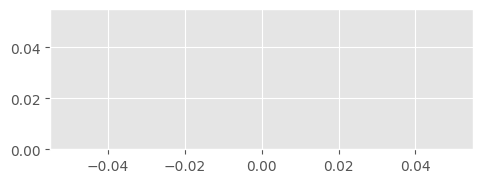

In [12]:
# ERROR. I have no idea why.
# with pm.Model() as comparing_groups_inputs:
#     μ = pm.HalfNormal('μ', sigma=5, shape=groups_i)
#     σ = pm.HalfNormal('σ', sigma=1, shape=groups_i)

#     y = pm.Gamma('y', mu=μ[idx_i], sigma=σ[idx_i], observed=inputs)

#     idata_i = pm.sample()

# az.plot_trace(idata_i)